# BA, 512², $n_p$ = 9

| Author  | Stanley A. Baronett  |
|---------|----------------------|
| Created |  12/06/2024          |
| Updated |  04/27/2025          |

In [1]:
#===============================================================================
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np
import pandas as pd

root = 'src'
model = 'unstratified'
problem = 'BA'
res = 512
n_ps = ['np1', 'np9']
runs = {
    f'dust_particles': {
        'ls': 'dotted',
        'codes' : {
            'Athena':       'tab:green',
            'Athena++':     'tab:red',
            'Pencil':       'tab:blue',
            'PLUTO':        'tab:pink',
        }
    }
}

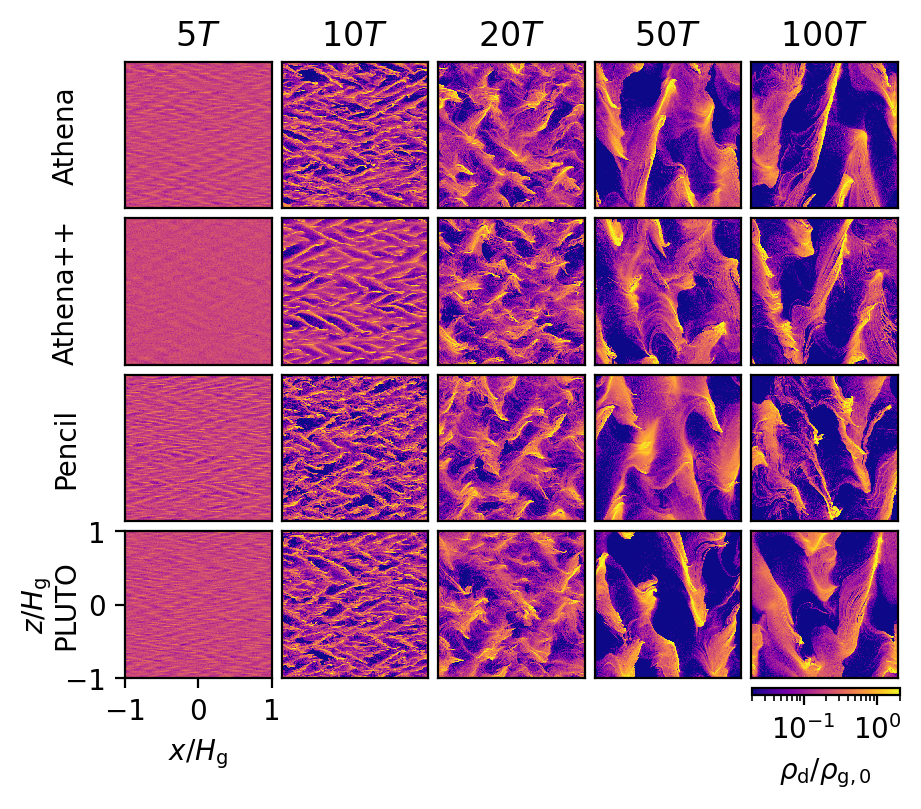

In [37]:
#===============================================================================
n_p = n_ps[-1]
times = [5, 10, 20, 50, 100]
vmin, vmax = 2e-2, 2e0 # BA CDF(rhod) > 90%; CDF(rhod) < 1%
nrows = 0
for key, value in runs.items():
    for code in value['codes']:
        nrows += 1

# Plot
fig = plt.figure(figsize=(8, 9*nrows/9), dpi=200)
ax_grid = AxesGrid(fig, 111, nrows_ncols=(nrows, len(times)), axes_pad=0.05,
                   share_all=True, label_mode='1')
j = 0
for key, value in runs.items():
    for code in value['codes']:
        path = f'{root}/{key}/{n_p}/{code}'
        row = j*len(times)
        for i, time in enumerate(times):
            if j == 0:
                ax_grid[i].set_title(rf'{time}$T$')
            if i == 0:
               ax_grid[row].text(-0.5, 0.5, f'{code}', rotation='vertical',
                                 va='center', transform=ax_grid[row].transAxes)
            snapshot = np.load(f'{path}/{time}.npz')
            x = snapshot['x']
            z = snapshot['z']
            try:
                rhod = snapshot['rhod']
            except KeyError:
                print(code)
            clip = np.clip(rhod, vmin, vmax)
            pcm = ax_grid[row+i].pcolormesh(x, z, clip, cmap='plasma',
                                            rasterized=True,
                                            norm=colors.LogNorm(vmin=vmin,
                                                                vmax=vmax))
            ax_grid[row+i].tick_params(bottom=False, left=False)
        j += 1

# Format plots
x1 = ax_grid[-1].get_position().x1 - 0.112
plt.colorbar(pcm, orientation='horizontal', shrink=0.119, anchor=(x1, -0.2),
             label=r'$\rho_\mathrm{d}/\rho_\mathrm{g,0}$')
bot_left = len(ax_grid)-len(times)
ax_grid[bot_left].set(xlabel=r'$x/H_\mathrm{g}$', ylabel=r'$z/H_\mathrm{g}$')
ax_grid[bot_left].xaxis.set_ticks([-1, 0, 1])
ax_grid[bot_left].yaxis.set_ticks([-1, 0, 1])
ax_grid[bot_left].tick_params(bottom=True, left=True)
plt.savefig(f'figs/{problem}-{res}-{n_p}_snapshots.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

np1 Athena samples
	  Total: 10001
	Strided: 1112
	Per 10T: 1000
np1 Athena++ samples
	  Total: 2000
	Strided: 1000
	Per 10T: 222
np1 Pencil samples
	  Total: 2925
	Strided: 1463
	Per 10T: 292
np1 PLUTO samples
	  Total: 1002
	Strided: 1002
	Per 10T: 111
np9 Athena samples
	  Total: 10001
	Strided: 1112
	Per 10T: 1000
np9 Athena++ samples
	  Total: 2001
	Strided: 1001
	Per 10T: 200
np9 Pencil samples
	  Total: 3070
	Strided: 1024
	Per 10T: 341
np9 PLUTO samples
	  Total: 1002
	Strided: 1002
	Per 10T: 111


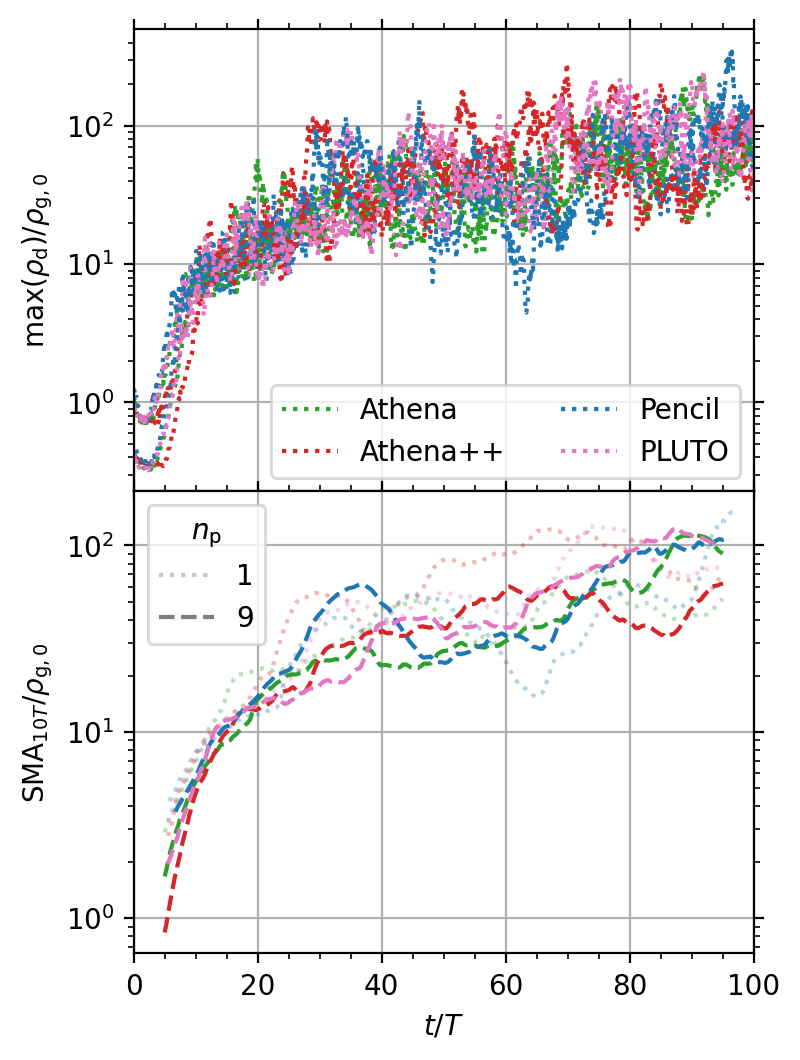

In [45]:
#===============================================================================
def print_samples(n_p, code, t, step, dt, window):
    """Print the number of samples in the time series."""
    print(f'{n_p} {code} samples\n=======================')
    print(f'\t  Total: {len(t)}')
    print(f'\tStrided: {len(t[::step])}')
    print(f'\tPer {dt}T: {window}')

diag = True
dt = 10  # [T]

# Lowest cadence
path = f'{root}/dust_particles/np1/PLUTO'
n_min = len(np.load(f'{path}/time_series.npz')['t'])

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=200)
c_handles, ls_handles = [], []
for n_p in n_ps:
    for key, value in runs.items():
        for code, color in value['codes'].items():
            path = f'{root}/{key}/{n_p}/{code}'
            data = np.load(f'{path}/time_series.npz')
            t = data['t']
            if n_p == 'np1':
                alpha = 0.33
                ls = value['ls']
                c_handles.append(axs[0].plot([],[], c=color, label=code,
                                             ls=ls)[0])
            else:
                alpha = 1.0
                ls = 'dashed'
            # Strided
            step = len(t)//n_min
            if step < 2:
                step = 1 if len(t)%n_min/n_min < 0.5 else 2
            try:
                axs[0].plot(t[::step], data['maxrhod'][::step], c=color,
                            ls=value['ls'])
            except KeyError:
                print(code)
            # SMA
            window = len(t)//int(t[-1]/dt)
            print_samples(n_p, code, t, step, dt, window) if diag else None
            df = pd.DataFrame(data=data['maxrhod'], index=t)
            df['sma'] = df.rolling(window, center=True).mean()
            axs[1].plot(df['sma'], alpha=alpha, c=color, ls=ls)

# Custom legends
axs[0].add_artist(axs[0].legend(framealpha=0.56, handles=c_handles,
                                loc='lower right', ncol=2))
ls_handles.append(axs[1].plot([], [], alpha=0.33, c='tab:gray', ls='dotted',
                              label='1')[0])
ls_handles.append(axs[1].plot([], [], c='tab:gray', ls='dashed', label='9')[0])
axs[1].add_artist(axs[1].legend(framealpha=0.56, handles=ls_handles,
                                loc='upper left', title=r'$n_\mathrm{p}$'))

# Format plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0].set(ylabel=rf'$\max(\rho_\mathrm{{d}})/\rho_\mathrm{{g,0}}$')
axs[1].set(xlabel=r'$t/T$', xlim=(0, 100), #ylim=(3e-2, 3e2),
           ylabel=rf'$\mathrm{{SMA}}_{{{dt}T}}/\rho_\mathrm{{g,0}}$')
fig.subplots_adjust(hspace=0)
plt.savefig(f'figs/{problem}-{res}-{n_p}_time_series.pdf', bbox_inches='tight',
            pad_inches=0.01)
plt.savefig(f'figs/{problem}-{res}-{n_p}_time_series.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

/tmp/ipykernel_5573/1072071530.py:43: RuntimeWarning: divide by zero encountered in log
  std = np.exp(np.std(np.log(n_p_stack), axis=0))
/home/stanley/miniconda3/envs/athena/lib/python3.11/site-packages/numpy/core/_methods.py:173: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


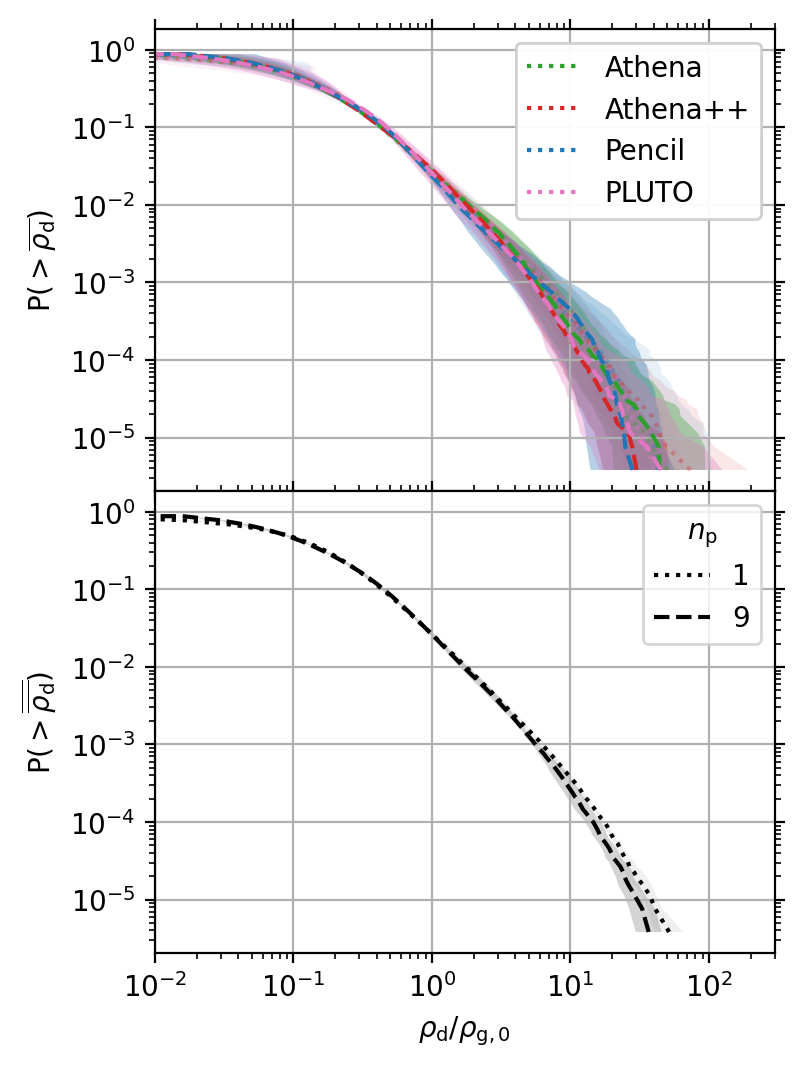

In [2]:
#===============================================================================
times = [20, 50, 100]  # [T]

# Plot
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(4, 6), dpi=200)
indices = -np.unique(np.logspace(np.log2(res**2), 0, num=100, base=2,
                     dtype=int))
c_handles = []
for n_p in n_ps:
    n_p_stack = []
    for key, value in runs.items():
        for code, color in value['codes'].items():
            path = f'{root}/{key}/{n_p}/{code}'
            rhods = []
            for i, time in enumerate(times):
                snapshot = np.load(f'{path}/{time}.npz')
                sort = np.sort(snapshot['rhod'], axis=None)
                rhods.append(sort)
            rhods = np.asarray(rhods)
            avgs = np.average(rhods, axis=0)
            cdf = np.linspace(1, 0, avgs.size, endpoint=False)
            log = np.log(np.clip(rhods, 1e-45, None))
            std_log = np.std(log, axis=0)
            stds = np.clip(np.exp(std_log), None, 3)
            cdf = np.take_along_axis(cdf, indices, 0)
            avgs = np.take_along_axis(avgs, indices, 0)
            stds = np.take_along_axis(stds, indices, 0)
            if n_p == 'np1':
                alpha = 0.33
                ls = value['ls']
                hatch = None
                c_handles.append(axs[0].plot([],[], c=color, label=code,
                                             ls=ls)[0])
            else:
                alpha = 1.0
                ls = 'dashed'
            axs[0].plot(avgs, cdf, alpha=alpha, c=color, ls=ls)
            axs[0].fill_betweenx(cdf, avgs/stds, avgs*stds, alpha=alpha/3,
                                 color=color, ec=None)
            n_p_stack.append(avgs)
    n_p_stack = np.asarray(n_p_stack)
    avg = np.average(n_p_stack, axis=0)
    std = np.exp(np.std(np.log(n_p_stack), axis=0))
    axs[1].plot(avg, cdf, c='k', label=n_p[-1], ls=ls)
    axs[1].fill_betweenx(cdf, avg/std, avg*std, alpha=alpha/3, color='tab:gray',
                         ec=None)

# Custom legends
axs[0].add_artist(axs[0].legend(handles=c_handles))

# Format plots
for ax in axs:
    ax.grid()
    ax.minorticks_on()
    ax.set(xscale='log', yscale='log')
    ax.tick_params(axis='both', which='both', top=True, right=True)
axs[0].legend()
axs[0].set(ylabel=r'P$(>\overline{\rho_\mathrm{d}})$')
axs[1].legend(title=r'$n_\mathrm{p}$')
axs[1].set(xlim=(1e-2, 3e2),
           xlabel=r'$\rho_\mathrm{d}/\rho_\mathrm{g,0}$',
           ylabel=r'P$(>\overline{\overline{\rho_\mathrm{d}}})$')
fig.subplots_adjust(hspace=0)
plt.savefig(f'figs/{problem}-{res}-{n_p}_CDF.pdf', bbox_inches='tight',
            pad_inches=0.01)
plt.savefig(f'figs/{problem}-{res}-{n_p}_CDF.png', dpi=600, bbox_inches='tight',
            pad_inches=0.01)

## Data compliance

### Athena

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np9'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena'
prefix = 'rhop-'
suffix = '-orbit.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'
times = [5, 10, 20, 50, 100]

# Load separate grid
steal = f'{path}/../Athena++'
grid = np.load(f'{steal}/old/grid_varz.npz', mmap_mode='r')
x = grid['x']
z = grid['z']

# Inspect
# np.load(f'{path}/old/{prefix}{times[1]:04}{suffix}', mmap_mode='r').files
# np.shape(snapshot['rhod'])

# Standardize
for time in times:
    snap = np.load(f'{path}/old/{prefix}{time:04}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        rhod=snap['par_density'].transpose())

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np9'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena'
fname = 'time_vs_max_density.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
np.load(f'{path}/old/{fname}', mmap_mode='r').files

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['time'],
                    maxrhod=time_series['max_density'])


### Athena++

In [ ]:
import numpy as np

code = 'Athena++'
prefix = 'rhop'
suffix = '.npz'
path = f'{root}/dust_particles/np9/{code}'
times = [0, 5, 10, 20, 50, 100]

# Load separate grid
grid = np.load(f'{path}/old/grid_varz.npz', mmap_mode='r')
x = grid['x']
z = grid['z']

# Inspect
# np.load(f'{path}/old/{prefix}{times[1]}{suffix}', mmap_mode='r').files
# np.shape(snap['rhop'])

# Standardize
for time in times:
    snap = np.load(f'{path}/old/{prefix}{time}{suffix}')
    np.savez_compressed(f'{path}/{time}', x=x, z=z,
                        rhod=snap['rhop'])

In [ ]:
import numpy as np

root = f'/home/stanley/github/pfitsplus/sicc/data'
model = 'unstratified'
problem = 'BA'
dust = 'particles'
n_p = 'np9'
res = 512
variation = f'dust_{dust}/{n_p}/{res}'
code = 'Athena++'
fname = 'time_series_rhopmax.npz'
path = f'{root}/{model}/{problem}/{variation}/{code}'

# Inspect
np.load(f'{path}/old/{fname}', mmap_mode='r').files

# Standardize
time_series = np.load(f'{path}/old/{fname}')
half = int(len(time_series['t'])/2)
np.savez_compressed(f'{path}/time_series', t=time_series['t'],
                    maxrhod=time_series['rhopmax'])


### Pencil

In [ ]:
code = 'Pencil'
path = f'{root}/dust_particles/np9/{code}'
times = [5, 10, 20, 50, 100]

# Inspect
# np.load(f'{path}/old/{times[0]}.npz', mmap_mode='r').files
snap = np.load(f'{path}/old/{times[0]}.npz', mmap_mode='r')
snap['array3'].shape
# out = np.reshape(snap['rhop'], (512, 512))
# np.shape(out)

# # Standardize
for time in times:
    snap = np.load(f'{path}/old/{time}.npz')
    np.savez_compressed(f'{path}/{time}', x=snap['array1'], z=snap['array2'],
                        rhod=snap['array3'])

In [ ]:
code = 'Pencil'
path = f'{root}/dust_particles/np9/{code}'
fname = 'time_series.npz'

# Inspect
time_series = np.load(f'{path}/old/{fname}', mmap_mode='r')
# time_series['array1']

# Standardize
time_series = np.load(f'{path}/old/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['array1']/2/np.pi,
                    maxrhod=time_series['array2'])


### PLUTO

In [ ]:
code = 'PLUTO'
path = f'{root}/dust_particles/np9/{code}'
folder = 'NP9_V3'
times = [5, 10, 20, 50, 100]

# Inspect
# np.load(f'{path}/{folder}/{times[0]}.npz', mmap_mode='r').files
# snap = np.load(f'{path}/{folder}/{times[0]}.npz', mmap_mode='r')
# out = np.reshape(snap['rhop'], (512, 512))
# np.shape(out)

# # Standardize
for time in times:
    snap = np.load(f'{path}/{folder}/{time}.npz')
    np.savez_compressed(f'{path}/{time}', x=snap['x'], z=snap['x'],
                        rhod=snap['rhop'].reshape(512, 512).transpose())

In [ ]:
code = 'PLUTO'
path = f'{root}/dust_particles/np9/{code}'
folder = 'NP9_V3'
fname = 'time_series.npz'

# Inspect
np.load(f'{path}/{folder}/time_series.npz', mmap_mode='r')

# Standardize
time_series = np.load(f'{path}/{folder}/{fname}')
np.savez_compressed(f'{path}/time_series', t=time_series['t']/2/np.pi,
                    maxrhod=time_series['maxrhop'])
